In [1]:
!rm -r /content/sample_data # i hate  this folder a lot

In [2]:
import gdown
path = 'https://drive.google.com/file/d/1zyQhaAfcAjbELA78hzDPFl89NS2il-iR/view?usp=share_link'
link = path.split('/')
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={link[-2]}",
    'data.rar'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1zyQhaAfcAjbELA78hzDPFl89NS2il-iR
To: /content/data.rar
100%|██████████| 8.10G/8.10G [00:59<00:00, 136MB/s]


'data.rar'

In [3]:
%%capture
!unrar x '/content/data.rar' '/content'

In [4]:
path = 'https://drive.google.com/file/d/1wwuQp2vn8-_hUkdpsI-fLr5yR-L6pqzF/view?usp=sharing'
link = path.split('/')
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={link[-2]}",
    'data_June.zip'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wwuQp2vn8-_hUkdpsI-fLr5yR-L6pqzF
To: /content/data_June.zip
100%|██████████| 2.62G/2.62G [00:20<00:00, 127MB/s]


'data_June.zip'

In [5]:
%%capture
!unzip data_June.zip

In [6]:
%%capture
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install -U albumentations
!pip install wandb

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
#import wandb

print('albumentations :', A.__version__)
print('pytorch_lightning :', pl.__version__)
print("torch :", torch.__version__)

albumentations : 1.3.0
pytorch_lightning : 1.9.0
torch : 1.13.1+cu116


In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, s1, s2, s3, months=None, labels=None, trans=None ,chip_ids=None):
        self.images = images
        self.labels = labels
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.chip_ids = chip_ids
        self.months= months or ['September'] #['September', 'June', 'July', 'August']
        self.trans=trans

                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        s1s, s2s, s3s = [], [], []
        paths = self.images[ix]
        if self.s1 is not None:
            for month in self.months:
                path = paths['S1'][month]
                #path = paths['S1'] # this is for only one month
                #print(path)
                if path is None:
                    s1s.append(np.zeros((3,256, 256)))
                else:
                    s1 = cv2.imread(path)
                    s1_ = cv2.cvtColor(s1, cv2.COLOR_BGR2RGB)
                    img_ = torch.from_numpy(s1_).permute(2,0,1)
                    img_OUT = img_/255
                    s1s.append(img_OUT)
        if self.s2 is not None:
            for month in self.months:
                path = paths['S2'][month]
                #path = paths['S2'] # this is for only one month
                if path is None:
                    s2s.append(np.zeros((3,256, 256)))
                else:
                    s2 = cv2.imread(str(path))
                    s2_ = cv2.cvtColor(s2, cv2.COLOR_BGR2RGB)
                    img_ = torch.from_numpy(s2_).permute(2,0,1)
                    img_OUT = img_/255
                    s2s.append(img_OUT)
        if self.s3 is not None:
            for month in self.months:
                path = paths['S3'][month]
                #path = paths['S3'] # this is for only one month
                if path is None:
                    s3s.append(np.zeros((3,256, 256)))
                else:
                    s3 = cv2.imread(str(path))
                    s3_ = cv2.cvtColor(s3, cv2.COLOR_BGR2RGB)
                    img_ = torch.from_numpy(s3_).permute(2,0,1)
                    img_OUT = img_/255
                    s3s.append(img_OUT)
                    
        s1s = np.stack([img for img in s1s]).astype(np.float32) if len(s1s) > 0 else None
        s2s = np.stack([img for img in s2s]).astype(np.float32) if len(s2s) > 0 else None
        s3s = np.stack([img for img in s3s]).astype(np.float32) if len(s3s) > 0 else None
        #conca = np.concatenate((s2s, s3s), axis = 1)
        # np.stack([trans['image'].transpose(2, 0, 1)] +[trans[f'image_s1_{i}'].transpose(2, 0, 1) for i in range(len(s1s)-1)]).astype(np.float32
        # np.stack([trans[f'image_s2_{i}'].transpose(2, 0, 1) for i in range(len(s2s))]).astype(np.float32),
        # self.labels[ix]
        if self.labels is not None:
            segmentation_npz = np.load(self.labels[ix])
            segmentation_map = segmentation_npz['arr_0']
            
            #print(s1s.shape, s2s.shape, segmentation_map.shape)
            # ver: https://albumentations.ai/docs/getting_started/mask_augmentation/
            # https://github.com/juansensio/competis/blob/master/TheBioMassters/bck/src/ds.py
            #print(s1s.shape, s1s.dtype, s2s.shape, s2s.dtype)
            # que peresa me d´pa hacer esto: 9:40 am
            if self.trans:
                #print("estoy haciendo transforms")
                # tres pasos:
                # 1 generar los parámetros:
                #params = {'image': s1s[0].transpose(1, 2, 0) , 'mask': segmentation_map}
                #print(s1s[0].shape)
                # for i in range(1, len(s1s)):
                #     params[f'image_s1_{i}'] = s1s[i].transpose(1, 2, 0)
                # for i in range(len(s2s)):
                #     params[f'image_s2_{i}'] = s2s[i].transpose(1, 2, 0)
                # for i in range(len(s3s)):
                #     params[f'image_s3_{i}'] = s3s[i].transpose(1, 2, 0)
                # 2 aplicar las transformaciones 
                # t = self.trans(**params)
                
                t = self.trans( image = s1s.squeeze(0).transpose(1, 2, 0), 
                               image0 = s2s.squeeze(0).transpose(1, 2, 0), 
                               image1 = s3s.squeeze(0).transpose(1, 2, 0), 
                               mask = segmentation_map)
                # 3 extraer las imágenes y unirlas con np.stack 
                #np.expand_dims(x, axis=0)
                # s1s = np.stack([t['image'].transpose(2, 0, 1)]      + [t['image_s1_1'].transpose(2, 0, 1)] + [t['image_s1_2'].transpose(2, 0, 1)])
                # s2s = np.stack([t['image_s2_0'].transpose(2, 0, 1)] + [t['image_s2_1'].transpose(2, 0, 1)] + [t['image_s2_2'].transpose(2, 0, 1)])
                # s3s = np.stack([t['image_s3_0'].transpose(2, 0, 1)] + [t['image_s3_1'].transpose(2, 0, 1)] + [t['image_s3_2'].transpose(2, 0, 1)])
                # segmentation = t['mask']
                #print(s1s[0].shape)
                s1s = np.expand_dims(t['image'].transpose(2, 0, 1), axis=0)
                s2s = np.expand_dims(t['image0'].transpose(2, 0, 1), axis=0)
                s3s = np.expand_dims(t['image1'].transpose(2, 0, 1), axis=0)
                segmentation = t['mask']
               # print(s1s.shape, s2s.shape, segmentation_map.shape)
                #segmentation = segmentation_map
            else:
                segmentation = segmentation_map
            
            #conca = np.concatenate((s2s, s3s), axis = 1)
            #print(s2s.shape, s3s.shape, conca.shape)
            
            return s1s, s2s, s3s, segmentation

        assert self.chip_ids is not None

        return s1s, s2s, s3s, self.chip_ids[ix]

In [10]:
class DataModule(pl.LightningDataModule):
    def __init__(self, s1=True, s2=True, s3=True, month = None, batch_size=32, num_workers=0, pin_memory=False, val_size=0, random_state=42):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.val_size = val_size
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.month = month
        self.random_state = random_state
        add_targets =  {'image_s1_1': 'image', 
                        'image_s1_2': 'image',
                        'image_s2_0': 'image', 
                        'image_s2_1': 'image',
                        'image_s2_2': 'image', 
                        'image_s3_0': 'image',
                        'image_s3_1': 'image', 
                        'image_s3_2': 'image',}

        self.transform = A.Compose([
                    #A.Transpose(),
                    A.Rotate(),
                    A.HorizontalFlip(),
                    A.VerticalFlip(),
                    #A.RandomRotate90(),
                    A.Flip(),
                ],additional_targets = {'image0': 'image', 'image1': 'image'}) #{'image0': 'image', 'image1': 'image'}

    def setup(self, stage=None):
        # read json files
        train = pd.read_json('https://raw.githubusercontent.com/sandroormeno/TheBioMassters/main/train_2.json')
        test = pd.read_json('https://raw.githubusercontent.com/sandroormeno/TheBioMassters/main/test.json')
        
        val = None
        # validation split
        if self.val_size > 0:
            train, val = train_test_split(train, test_size=self.val_size, random_state=self.random_state)
        # generate datastes
        #self.ds_train = Dataset(train.filename.values,self.s1, self.s2, self.s3, train.label.values) # sin transform
        self.ds_train = Dataset(train.filename.values,self.s1, self.s2, self.s3, self.month, train.label.values, self.transform)
        #self.ds_train = Dataset(train.filename.values,self.s1, self.s2, train.label.values) # for overfitting
        self.ds_val = None
        if val is not None:
            self.ds_val = Dataset(val.filename.values, self.s1, self.s2, self.s3, self.month, val.label.values)
        self.ds_test = Dataset(test.filename.values,self.s1, self.s2, self.s3, self.month, chip_ids = test.index.values)
        print('train:', len(self.ds_train))
        if self.ds_val is not None:
            print('val:', len(self.ds_val))
        print('test:', len(self.ds_test))
    def get_dataloader(self, ds, batch_size=None, shuffle=None):
        return DataLoader(
            ds,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=shuffle if shuffle is not None else True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=collate_fn
        ) if ds is not None else None

    def train_dataloader(self, batch_size=None, shuffle=True):
        return self.get_dataloader(self.ds_train, batch_size, shuffle)

    def val_dataloader(self, batch_size=None, shuffle=False):
        return self.get_dataloader(self.ds_val, batch_size, shuffle)

    def test_dataloader(self, batch_size=None, shuffle=False):
        return self.get_dataloader(self.ds_test, batch_size, shuffle)

def collate_fn(batch):
    #s1s, s2s, labels = zip(*batch) # two sensors
    s1s, s2s, s3s, labels = zip(*batch)
    s1s = torch.from_numpy(np.stack(s1s)) if s1s[0] is not None else None
    s2s = torch.from_numpy(np.stack(s2s)) if s2s[0] is not None else None
    s3s = torch.from_numpy(np.stack(s3s)) if s3s[0] is not None else None
    #return (s1s, s2s), labels if isinstance(labels[0], str) else torch.from_numpy(np.stack(labels)) # two sensors
    return (s1s, s2s, s3s), labels if isinstance(labels[0], str) else torch.from_numpy(np.stack(labels))

In [11]:
dm = DataModule(month = ['June'] , batch_size=4, val_size=0.1) #['September','June', 'July', 'August']
dm.setup()

train: 7820
val: 869
test: 2773


In [12]:
# for test
ima, labels = next(iter(dm.train_dataloader()))
ima[0].shape, ima[1].shape, ima[2].shape

(torch.Size([4, 1, 3, 256, 256]),
 torch.Size([4, 1, 3, 256, 256]),
 torch.Size([4, 1, 3, 256, 256]))

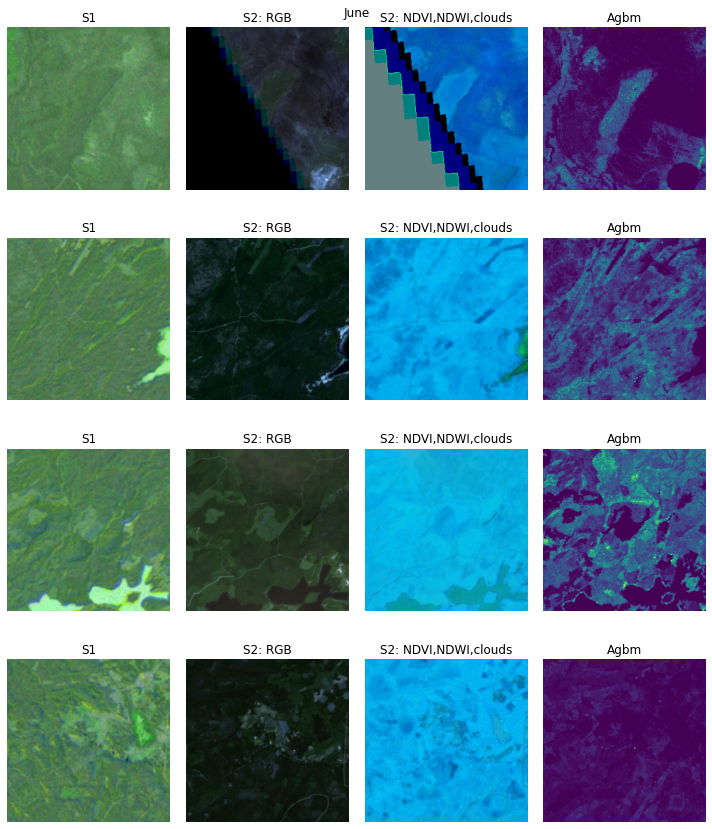

In [13]:
all, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1, s2, s3 = all
fig = plt.figure(figsize=(10, 12))
month = 0
fig.suptitle(dm.month[0])
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    #ax.set_title(str(s1[i][0].shape))
    ax.set_title("S1")
    ax.imshow(s1[i][month].permute(1, 2, 0))
    #ax.imshow(s1[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    #ax.set_title(str(s2[i][0].shape))
    ax.set_title("S2: RGB")
    ax.imshow(s2[i][month].permute(1, 2, 0))
    #ax.imshow(s2[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    #ax.set_title(str(s3[i][0].shape))
    ax.set_title("S2: NDVI,NDWI,clouds")
    ax.imshow(s3[i][month].permute(1, 2, 0))
    #ax.imshow(s3[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    #ax.set_title(str(labels[i].shape))
    ax.set_title("Agbm")
    ax.imshow(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
class BaseModule(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        self.save_hyperparameters(hparams)

    def forward(self, x, y=None):
        raise NotImplementedError

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self(x)

    def compute_loss(self, y_hat, y):
        loss = torch.mean(torch.sqrt(torch.mean((y_hat - y)**2, dim=(1, 2))))
        return loss

    def compute_metrics(self, y_hat, y):
        metric = self.compute_loss(y_hat * 12905.3, y * 12905.3)
        return metric

    def shared_step(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        metric = self.compute_metrics(y_hat, y)
        return loss, metric

    def training_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('loss', loss)
        self.log('metric', metric, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_metric', metric, prog_bar=True)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer)(
            self.parameters(), **self.hparams['optimizer_params'])
        if 'scheduler' in self.hparams:
            schedulers = [
                getattr(torch.optim.lr_scheduler, scheduler)(
                    optimizer, **params)
                for scheduler, params in self.hparams.scheduler.items()
            ]
            return [optimizer], schedulers
        return optimizer

In [15]:
import segmentation_models_pytorch as smp
#from einops import rearrange

class UNet(BaseModule):
    def __init__(self, hparams=None):
        super().__init__(hparams)
        self.unet1 = smp.Unet(
            encoder_name=self.hparams.encoder,
            encoder_weights=self.hparams.pretrained,
            in_channels=self.hparams.in_channels1,
            classes=1,
        )
        self.unet2 = smp.Unet(
            encoder_name=self.hparams.encoder,
            encoder_weights=self.hparams.pretrained,
            in_channels=self.hparams.in_channels2,
            classes=1,
        )
        self.unet3 = smp.Unet(
            encoder_name=self.hparams.encoder,
            encoder_weights=self.hparams.pretrained,
            in_channels=self.hparams.in_channels3,
            classes=1,
        )       
        #self.comv_out = torch.nn.Conv2d(3,1,1)
        self.comv_out = torch.nn.Conv2d(3,1,3, padding=1)

    def forward(self, x):
        s1s, s2s, s3s = x
        B,L,_,_,_ = s2s.shape
        '''
        x = torch.tensor([], device=self.device, dtype=torch.float32)
        if s2s is not None:
            x = torch.cat((x, s2s), dim=2)
        if s1s is not None:
            x = torch.cat((x, s1s), dim=2)
        '''
        #s1 = rearrange(s1s, 'b m c h w -> b (m c) h w')
        #s2 = rearrange(s2s, 'b m c h w -> b (m c) h w')
        #s3 = rearrange(s3s, 'b m c h w -> b (m c) h w')
        #x1 = self.unet1(s1)
        #x2 = self.unet1(s2)
        #x3 = self.unet1(s3)
        x1 = self.unet1(s1s.squeeze(1))
        x2 = self.unet2(s2s.squeeze(1))
        x3 = self.unet3(s3s.squeeze(1))
        x_ = torch.cat((x1,x2,x3), dim =1)
        #xtomodel = rearrange(x_, '(b m) c h w -> b (m c) h w', b = B)
        out = self.comv_out(x_)
        return torch.sigmoid(out).squeeze(1)

In [16]:
# test the model
hparams = {
    'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels1': 3,
    'in_channels2': 3,
    'in_channels3': 3,
}
model = UNet(hparams)
outputs = model(all)
outputs.shape

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([4, 256, 256])

In [17]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
!ls '/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints'

'June-3-sat-110e-epoch=84.ckpt'
'June-3-sat-110e-val_metric=35.20265-epoch=84.ckpt'


In [19]:
resume_from_checkpoint = '/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints/June-3-sat-110e-epoch=84.ckpt'
config = {
    'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels1': 3,
    'in_channels2': 3,
    'in_channels3': 3,
    'optimizer': 'Adam',
    'optimizer_params': {
        'lr': 1e-3
    },
    'trainer': {
        
        'gpus': 1,
        'resume_from_checkpoint': resume_from_checkpoint,
        'max_epochs': 110,
        'logger': True,
        'enable_checkpointing': True,
        'overfit_batches': 0,
        'deterministic': True,
        'precision': 16,
        'log_every_n_steps': 100
    },
    'datamodule': {
        'month' : ['June'],
        'batch_size': 64,
        'val_size': 0.1,
        'num_workers': 0,
        'pin_memory': True 
    },
}

In [20]:
# activate Drive
path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints"
def train(config, name):
    pl.seed_everything(21, workers=True)
    dm = DataModule(**config['datamodule'])

    module = UNet(config)
    #module = UNet(hparams)
    #module.load_state_dict(state_dict)

    config['trainer']['callbacks'] = []
    if config['trainer']['enable_checkpointing']:
        config['trainer']['callbacks'] += [
            ModelCheckpoint(
                dirpath = path_checkpoints,
                filename=f'{name}-{{val_metric:.5f}}-{{epoch}}',
                monitor='val_metric',
                mode='min',
                save_top_k=1
            ),
            ModelCheckpoint(
                dirpath = path_checkpoints,
                filename=f'{name}-{{epoch}}',
                monitor='epoch',
                mode='max',
                save_top_k=1
            )
        ]
    if config['trainer']['logger']:
        config['trainer']['logger'] = WandbLogger(
            project="The_BioMassters_v1",
            name=name,
            config=config
        )
        if 'scheduler' in config and config['scheduler']:
            config['trainer']['callbacks'] += [
                LearningRateMonitor(logging_interval='step')]

    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)

In [21]:
train(config, "June-3-sat-110e")

INFO:lightning_fabric.utilities.seed:Global seed set to 21
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:55: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v2.0. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs

train: 7820
val: 869
test: 2773


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type   | Params
------------------------------------
0 | unet1    | Unet   | 14.3 M
1 | unet2    | Unet   | 14.3 M
2 | unet3    | Unet   | 14.3 M
3 | comv_out | Conv2d | 28    
------------------------------------
43.0 M    Trainable params
0         Non-trainable params
43.0 M    Total params
85.969    Total estimated model params size (MB)
wandb: Currently logged in as: sandro_og. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints/June-3-sat-110e-epoch=84.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 123it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/lightning_fabric/plugins/io/torch_io.py:61: UserWarning: Warning, `hyper_parameters` dropped from checkpoint. An attribute is not picklable: Can't pickle local object 'EvaluationLoop.advance.<locals>.batch_to_device'
  rank_zero_warn(f"Warning, `{key}` dropped from checkpoint. An attribute is not picklable: {err}")


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=110` reached.
